# Проект 

**Краткая суть**

Необходимо обучить модель классифицировать возраст людей по фотографии

**Описание**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 * Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 * Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.


**Критерии оценки модели**

* Значение метрики МАЕ на тестовой выборке должно быть не меньше 7

**План выполнения проекта**

1. Произвести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.
4. Сделать выводы

# Определение возраста покупателей

## Исследовательский анализ данных

### Импортируем библиотеки

In [3]:
import pandas as pd
import numpy as np

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt


plt.style.use('dark_background')

### Загрузим данные и посмотрим на них

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=22) 

Found 7591 validated image filenames.


In [7]:
def check_values(column):  # напишем функцию для построения графика и описательной статистики
    column.hist(bins=100)
    plt.title('Распределение возраста в выборке', fontsize=18, fontweight="bold")
    plt.xlabel('Возраст', fontsize=10, fontweight="bold")
    plt.ylabel('Часота', fontsize=10, fontweight="bold")
    plt.show()
    
    print(column.describe())

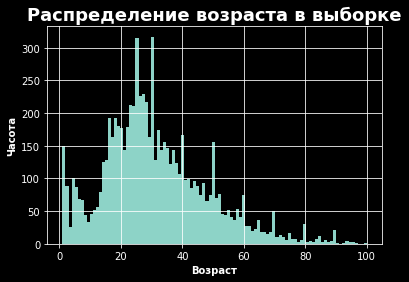

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [8]:
check_values(labels['real_age']) # применим функцию к столбцу с возрастом

В нашем датасете всего 7591 фотография. Средний возраст 30 лет, самому младшему на фото 1 год, самому старшему 100 лет. Можно заметить, что здесь правостороннее распределение, это значит что ***мода*** < ***медиана*** < ***среднее***. Интересен следующий момент: в выборке есть пики(выбросы) на каждый 5 и 10 год, выглядит так, будто люди сами округлили свой возраст прибавив/отняв несколько лет. Если это так, то это может сильно искажать данные.

### Выведем 15 фотографий

In [6]:
features, target = next(train_gen_flow)

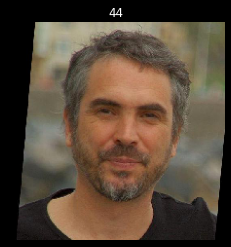

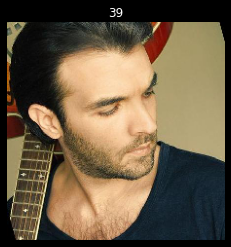

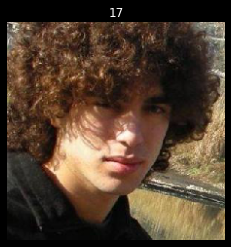

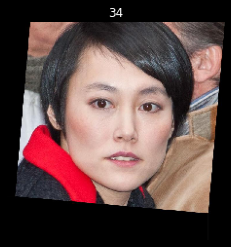

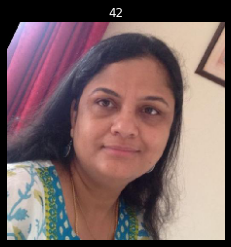

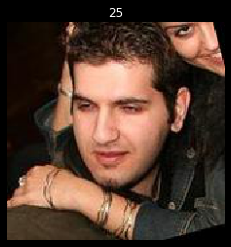

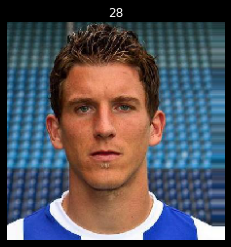

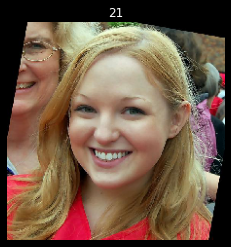

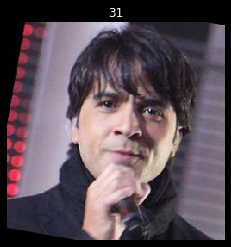

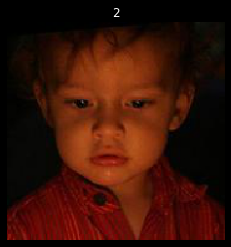

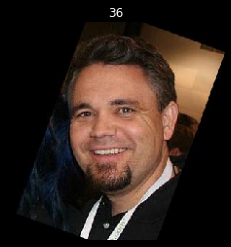

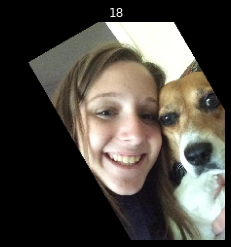

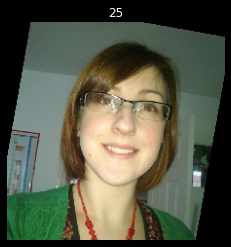

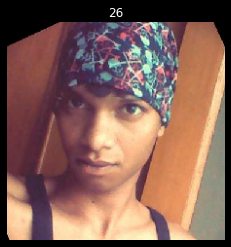

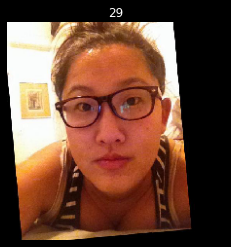

In [7]:
for photo, age in zip(features[:15], target[:15]):
    plt.figure()
    plt.axis('off')
    plt.title(age)
    plt.imshow(photo)

Подытожим:

- на фото у кого-то лицо затемнено, кто-то с микрофоном, кто-то в очках, кто-то в головном уборе, кто-то расположен боком - все это будет создавать проблемы для модели.
- необходимо примеить аугментацию к изображениям, для генерации "новых" данных для обучения, т к данных маловато
- выборка искажена изначально (выбросами каждые 5-10 лет)

## Обучение модели

### Напишем функции для загрузки тренировочной и тестовой выборок, для создания и обучения модели.

In [8]:
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        rotation_range=20,
        seed=22)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        horizontal_flip=True,
        rotation_range=20,
        seed=22)
    return test_datagen_flow
  
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

In [9]:
# 178/178 - 63s - loss: 243.0247 - mae: 11.1088 - val_loss: 729.8476 - val_mae: 22.1786
# Epoch 2/10
# 178/178 - 44s - loss: 66.2972 - mae: 6.2266 - val_loss: 798.2614 - val_mae: 23.4618
# Epoch 3/10
# 178/178 - 44s - loss: 31.5464 - mae: 4.3608 - val_loss: 565.7640 - val_mae: 18.9953
# Epoch 4/10
# 178/178 - 50s - loss: 19.9579 - mae: 3.4901 - val_loss: 125.2861 - val_mae: 8.7275
# Epoch 5/10
# 178/178 - 43s - loss: 14.8152 - mae: 2.9731 - val_loss: 79.9647 - val_mae: 6.9010
# Epoch 6/10
# 178/178 - 42s - loss: 10.2117 - mae: 2.4228 - val_loss: 75.1744 - val_mae: 6.6198
# Epoch 7/10
# 178/178 - 40s - loss: 7.9188 - mae: 2.1432 - val_loss: 72.4862 - val_mae: 6.3676
# Epoch 8/10
# 178/178 - 37s - loss: 7.1415 - mae: 2.0303 - val_loss: 68.4743 - val_mae: 6.1819
# Epoch 9/10
# 178/178 - 37s - loss: 6.2873 - mae: 1.9226 - val_loss: 68.4254 - val_mae: 6.1439
# Epoch 10/10
# 178/178 - 38s - loss: 5.8264 - mae: 1.8455 - val_loss: 65.3117 - val_mae: 6.0967
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to  
#   ['...']
# 60/60 - 9s - loss: 65.3117 - mae: 6.0967
# Test MAE: 6.0967

## Анализ обученной модели

**Вывод:**

*Нам нужно было создать и обучить модель для классификации пользователей по фотографии. У нас был датафрейс с 7.5 тыс. размеченных фотографий. Данные лежали на сервере, нужно было написать "загрузчик" и обучить модель. Данные в выборке изначально были искажены самими людьми округлением возраста.*

*Обучали нейронную сеть архитектуры ResNet50, адаптировав под нашу задачу, т е убрав верхушку и построив ее заново, веса использовались предобученные. В сеть подавалось 32 фотографии, использовался оптимизатор Adam. 
Модель обучилась достаточно быстро, так же 7 эпох (всего было 10) достаточно чтобы получить MAE 6.6
В итоге, модель способна определять возраст по фото с погрешностью +- 6 лет.*